# Does price skew negative or positve in January 2022 in the SPP ISO region?

To identify where a node is having a strong positive, negative, or indifferent LMP bias, I will compare the LMP values of the node with the LMP values of its neighboring nodes through January 2022. Here are the steps I will follow:

1. Calculate the average LMP value for the node and its neighboring nodes for each 5 minute period in Jan 2022.
2. Subtract the node's LMP value for that 5 min period from the average LMP value calculated in step 1 to get the bias value.
3. If the bias value is positive, the node has a positive LMP bias, indicating that it is receiving a higher LMP compared to its neighbors. If the bias value is negative, the node has a negative LMP bias, indicating that it is receiving a lower LMP compared to its neighbors. If the bias value is zero, the node has an indifferent LMP bias, indicating that it is receiving the same LMP as its neighbors.
4. For this analysis I will consider a strong bias to be within 2 standard deviations of the mean for that 5 min period

#### Load packages:

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

#### Load Data:

In [2]:
#Function that will pull data based on start and end date
def read_csv_files(start_date, end_date):
    data = []
    date = pd.to_datetime(start_date, format='%Y%m%d')
    end = pd.to_datetime(end_date, format='%Y%m%d')
    while date <= end:
        filename = "RTBM-LMP-DAILY-SL-" + date.strftime('%Y%m%d') + ".csv"
        df = pd.read_csv(filename)
        data.append(df)
        date += pd.DateOffset(days=1)
    return pd.concat(data)

In [3]:
#Select dates between 20220101 and 20220130 (Month of Jan 2022)
start_date = "20220101"
end_date = "20220130"
jan_22_df = read_csv_files(start_date, end_date)
jan_22_df[' GMT Interval'] = pd.to_datetime(jan_22_df[' GMT Interval'], format='%m/%d/%Y %H:%M:%S')
jan_22_df 

,Interval,GMT Interval,Settlement Location Name,PNODE Name,LMP,MLC,MCC,MEC
0,01/01/2022 00:05:00,2022-01-01 06:05:00,AEC,SOUC,28.4229,0.1388,24.9790,3.3051
1,01/01/2022 00:05:00,2022-01-01 06:05:00,AECC_CSWS,CSWS_AECC_LA,29.3969,0.1362,25.9557,3.3050
2,01/01/2022 00:05:00,2022-01-01 06:05:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,16.9652,0.0971,13.5631,3.3050
3,01/01/2022 00:05:00,2022-01-01 06:05:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,27.8842,0.1739,24.4053,3.3050
4,01/01/2022 00:05:00,2022-01-01 06:05:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,17.2851,0.0530,13.9271,3.3050
...,...,...,...,...,...,...,...,...
318235,01/31/2022 00:00:00,2022-01-31 06:00:00,WR_MOPEP_MPS,WR_MOPEP_MPS_LA,4.1600,-0.4424,-8.8968,13.4992
318236,01/31/2022 00:00:00,2022-01-31 06:00:00,WR_MW_KPP_NITS,WR_MW_KPP_NITS_LA,6.6183,-1.2139,-5.6670,13.4992
318237,01/31/2022 00:00:00,2022-01-31 06:00:00,WR_SEG,WR_SEG_LA,9.2777,-0.2168,-4.0048,13.4993
318238,01/31/2022 00:00:00,2022-01-31 06:00:00,WR_WR,WR_LA,5.8433,-0.7776,-6.8784,13.4993


# Create graph showing price on Y axis and time on X axis:

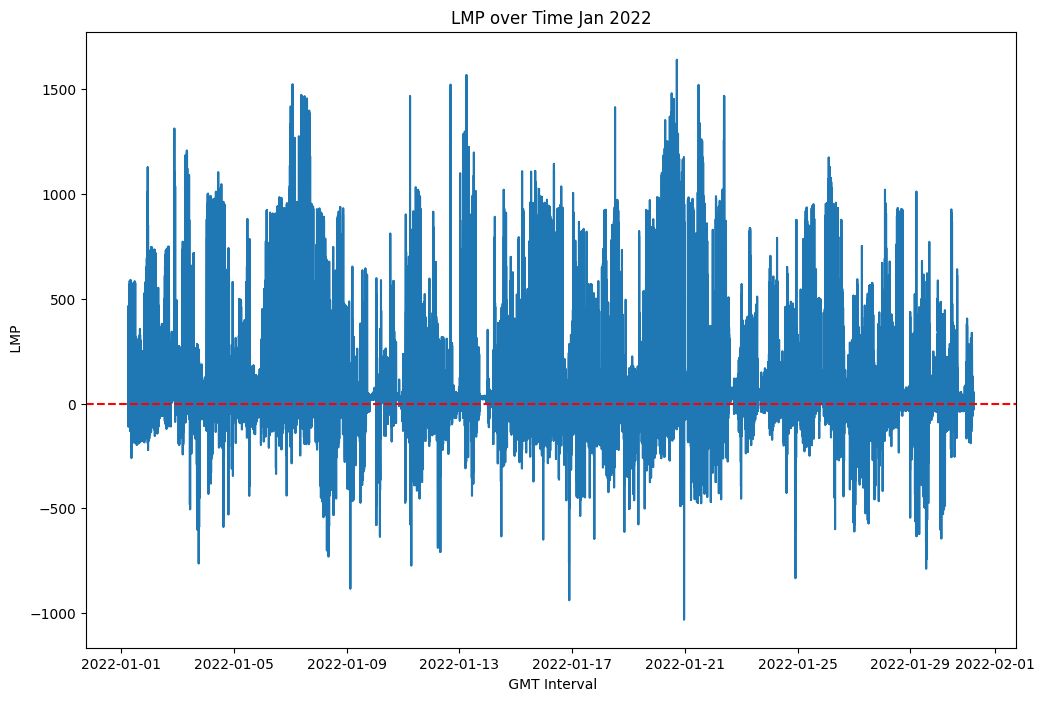

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(jan_22_df[' GMT Interval'], jan_22_df[' LMP'])
ax.axhline(y=0, color='r', linestyle='--')
plt.xlabel(' GMT Interval')
plt.ylabel(' LMP')
plt.title('LMP over Time Jan 2022')

plt.show()

#### Select one PNODE (SOUC) to examine across January could be repeated for any PNODE

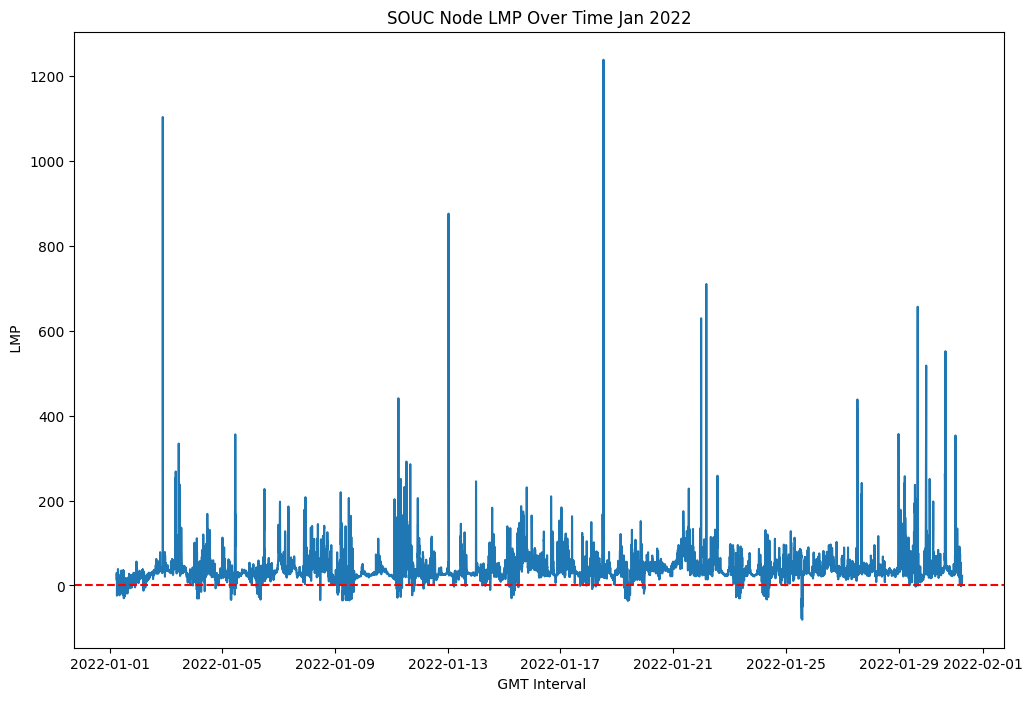

In [9]:
SOUC_jan_22_df = jan_22_df[jan_22_df[' PNODE Name'] == 'SOUC']
SOUC_jan_22_df[' GMT Interval'] = pd.to_datetime(SOUC_jan_22_df[' GMT Interval'], format='%m/%d/%Y %H:%M:%S')
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(SOUC_jan_22_df[' GMT Interval'], SOUC_jan_22_df[' LMP'])
ax.axhline(y=0, color='r', linestyle='--')
plt.xlabel(' GMT Interval')
plt.ylabel(' LMP')
plt.title('SOUC Node LMP Over Time Jan 2022')

plt.show()

# Identify where node is having a strong positve, negative, or indifferent bias:

### By 5 minute period:

In [18]:
#Function that groups jan_22_df by PNODE and time
def group_by_pnode_and_time(df, time_freq):
    unique_pnodes = df[' PNODE Name'].unique()
    result_dfs = []
    for pnode_name in unique_pnodes:
        pnode_df = df[df[' PNODE Name'] == pnode_name]
        pnode_df = pnode_df.set_index(' GMT Interval')
        grouped_df = pnode_df.groupby([pd.Grouper(freq=time_freq), ' PNODE Name'])[' LMP'].mean()
        grouped_df = grouped_df.reset_index()
        result_dfs.append(grouped_df)
    final_df = pd.concat(result_dfs)
    return final_df

In [19]:
grouped_df = group_by_pnode_and_time(jan_22_df, '5Min')

In [59]:
# Group the data by 5-minute intervals and calculate the mean for each 5 min period
mean_by_5min = grouped_df.groupby(pd.Grouper(key=' GMT Interval', freq='5T'))[' LMP'].mean()
mean_by_5min = pd.DataFrame(mean_by_5min)
mean_by_5min = mean_by_5min.rename(columns={' LMP': 'Mean_LMP_overall'})

In [44]:
merged_df = pd.merge(grouped_df, mean_by_5min, on=' GMT Interval')
merged_df['Bias'] = merged_df[' LMP'] - merged_df['Mean_LMP_overall']
merged_df['std'] = np.std(merged_df['Mean_LMP_overall'])
merged_df['upper_bound'] = merged_df['Mean_LMP_overall'] + (2 * merged_df['std'])
merged_df['lower_bound'] = merged_df['Mean_LMP_overall'] - (2 * merged_df['std'])
#Dummies for strong positive/ negative and indifferent 1 = yes
merged_df['strong_positive'] = np.where(merged_df[' LMP'] > merged_df['upper_bound'], 1, 0)
merged_df['strong_negative'] = np.where(merged_df[' LMP'] < merged_df['lower_bound'], 1, 0)
merged_df['indifferent'] = np.where(merged_df['Mean_LMP_overall'] == merged_df[' LMP'],1,0)
#lower_bound = mean - (2 * std)
pd.set_option('display.max_rows', None)

### Strong Positive

In [70]:
strong_positive_df = merged_df[merged_df['strong_positive'] == 1]
#Print first 4 Results of dataframe
strong_positive_df.head()

,GMT Interval,PNODE Name,LMP,Mean_LMP_overall,Bias,std,upper_bound,lower_bound,strong_positive,strong_negative,indifferent
62,2022-01-01 06:05:00,CSWSTUSKAHOMUNWILDHORSE_RA,105.4529,-1.088229,106.541129,36.350496,71.612763,-73.78922,1,0,0
87,2022-01-01 06:05:00,IDABEL_DDR,71.8314,-1.088229,72.919629,36.350496,71.612763,-73.78922,1,0,0
92,2022-01-01 06:05:00,LEHIGH_DDR,354.1607,-1.088229,355.248929,36.350496,71.612763,-73.78922,1,0,0
100,2022-01-01 06:05:00,MCALESTR_DDR,97.0676,-1.088229,98.155829,36.350496,71.612763,-73.78922,1,0,0
517,2022-01-01 06:05:00,BODLE_DDR,143.0854,-1.088229,144.173629,36.350496,71.612763,-73.78922,1,0,0


In [49]:
print('Number of observations that fall within strong positive:',strong_positive_df.shape[0])

Number of observations that fall within strong positive: 168880


In [64]:
#Number of times that a pnode appears in strong positive
count_by_pnode_name = strong_positive_df[' PNODE Name'].value_counts()
#Print top 20
count_by_pnode_name.head(20)

PSLO_MISO_WAUE_MPCN_LA            2292
BODLE_DDR                         2266
WFECTHOMAS2UNCENTRAHMA_EAST_RA    2072
WFECTHOMAS2UNCENTRAHOMA_RA        2072
EDEOZRK_BUN6_RA                   2071
EDEOZRK_BUN8_RA                   2071
EDEOZRK_BUN5_RA                   2071
EDEOZRK_BUN7_RA                   2071
WFEC_PEOP_LOAD_LA                 2040
LEHIGH_DDR                        2002
WFECCOLGATEUNLITTLEDIXIE_RA       1788
EDE_SWMP_LA                       1552
KCPLNORTH5UN6_RA                  1442
SPRM_NIXA_LA                      1438
SPRM_LA                           1412
SPRMSWPS5UN2_RA                   1386
SPRMSWPS5UN1_RA                   1386
SPRMSWPS5UNG1_RA                  1385
SPRMSWPS5UNUN_2_RA                1384
SPRMJRPS5UN6_RA                   1378
Name:  PNODE Name, dtype: int64

### Strong negative

In [69]:
strong_negative_df = merged_df[merged_df['strong_negative'] == 1]
strong_positive_df.head()

,GMT Interval,PNODE Name,LMP,Mean_LMP_overall,Bias,std,upper_bound,lower_bound,strong_positive,strong_negative,indifferent
62,2022-01-01 06:05:00,CSWSTUSKAHOMUNWILDHORSE_RA,105.4529,-1.088229,106.541129,36.350496,71.612763,-73.78922,1,0,0
87,2022-01-01 06:05:00,IDABEL_DDR,71.8314,-1.088229,72.919629,36.350496,71.612763,-73.78922,1,0,0
92,2022-01-01 06:05:00,LEHIGH_DDR,354.1607,-1.088229,355.248929,36.350496,71.612763,-73.78922,1,0,0
100,2022-01-01 06:05:00,MCALESTR_DDR,97.0676,-1.088229,98.155829,36.350496,71.612763,-73.78922,1,0,0
517,2022-01-01 06:05:00,BODLE_DDR,143.0854,-1.088229,144.173629,36.350496,71.612763,-73.78922,1,0,0


In [51]:
print('Number of observations that fall within strong negative:',strong_negative_df.shape[0])

Number of observations that fall within strong negative: 98916


In [67]:
#Number of times that a pnode appears in strong negative
count_by_pnode_name = strong_negative_df[' PNODE Name'].value_counts()
#Print top 20
count_by_pnode_name.head(20)

EDELAR3821UN4_RA                   1082
EDELAR3821UN3_RA                   1082
EDELAR3821UN1_RA                   1082
EDELAR3821UNKINGSPNT_RA            1082
EDELAR3821UN2_RA                   1082
WRCOLBY3UNGST_RA                    905
V116_DDR                            609
V112_DDR                            602
OKGE.VOLT.0032_H                    600
OKGEMCCLAIPLT1                      600
OPPDSUB1399UNFLATWTR_WIND_RA        591
PLVALLEY_DDR                        588
WR.VOLT.0016_H                      538
OPPD_MEAN_FCU_LA                    528
OKGECIMARRONUNCANADN5_WIND_RA       526
OKGECIMARRONUNKINGFSHR_WIND1_RA     526
OKGECIMARRONUNCANADN1_WIND_RA       526
GRDACMRN_GRDLDCANADN3_WIND_RA       526
OKGECIMARRONUNCANADN4_WIND_RA       526
OKGECIMARRONUNCANADN2_WIND_RA       526
Name:  PNODE Name, dtype: int64

### Indifferent

In [68]:
indifferent_df = merged_df[merged_df['indifferent'] == 1]
indifferent_df.head()

,GMT Interval,PNODE Name,LMP,Mean_LMP_overall,Bias,std,upper_bound,lower_bound,strong_positive,strong_negative,indifferent
5004895,2022-01-17 16:40:00,SOUC,0.0001,0.0001,0.0,36.350496,72.701092,-72.700892,0,0,1
5004896,2022-01-17 16:40:00,CSWS_AECC_LA,0.0001,0.0001,0.0,36.350496,72.701092,-72.700892,0,0,1
5004897,2022-01-17 16:40:00,CSWSELKINSUNELKINS_RA,0.0001,0.0001,0.0,36.350496,72.701092,-72.700892,0,0,1
5004898,2022-01-17 16:40:00,CSWSFITZHUGHPLT1,0.0001,0.0001,0.0,36.350496,72.701092,-72.700892,0,0,1
5004899,2022-01-17 16:40:00,CSWSFLINTCRKUN1_JOU_AECC_RA,0.0001,0.0001,0.0,36.350496,72.701092,-72.700892,0,0,1


In [55]:
print('Number of observations that have indifferent bias:',indifferent_df.shape[0])

Number of observations that have indifferent bias: 2114
